`page 198`

# Chapter 5

## Exercise 5

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [2]:
default = sm.datasets.get_rdataset('Default', package='ISLR').data
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
# Define the logistic regression model 
y, X = dmatrices('default ~ income + balance', data=default, return_type='dataframe')

# Fit the model
model = sm.Logit(y.iloc[:,1:], X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:           default[Yes]   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:                  0.4594
Time:                        10:52:22   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99

In [4]:
# Using Sklearn. I used different approach.
def logistic_reg(X, y):
    """ Take X and y and spits out validation set error rate. """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    classifier = LogisticRegression(solver='sag')
    lrm = classifier.fit(X_train, y_train)
    return "Accuracy: {:.2f}".format(lrm.score(X_test, y_test)) #incorrect. ".score()" returns R2, NOT accuracy

logistic_reg(default.iloc[:,2:], default['default'])

'Accuracy: 0.97'

In [5]:
# Explicit encoding
enc = LabelEncoder()
default['default'] = enc.fit_transform(default['default'])
default['student'] = enc.fit_transform(default['student'])

# Including the "student" variable
logistic_reg(default.iloc[:,1:], default['default'])

C:\Users\Ali Sina\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


'Accuracy: 0.97'

> Skipped exercise 6
***

## Exercise 7

In [6]:
weekly = sm.datasets.get_rdataset('Weekly', package='ISLR').data
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [7]:
# Using Patsy design matrix
y, X = dmatrices('Direction ~ Lag1 + Lag2', data=weekly, return_type='dataframe')

# Fit to logistic regression model
glm_fitted = sm.Logit(y.iloc[:,1], X).fit()

print(glm_fitted.summary())

Optimization terminated successfully.
         Current function value: 0.683297
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:                0.005335
Time:                        10:52:35   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                   0.01848
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.

In [8]:
# Construct a dummy dataframe of model predictions
preds = pd.DataFrame(np.zeros(shape=(1089, 1)), columns=['label'])

# Change into binary value of "UP" (1) if predictions (pobability) is > 0.5
preds.iloc[glm_fitted.predict() > 0.5] = 1

# Compare with first observation
preds.iloc[0] == y.iloc[:,1][0]

label    False
Name: 0, dtype: bool

> Skipped the LOOCV part. It could be easily done with the Sklearn's LeaveOneOut() function
***
## Exercise 8

In [9]:
random.seed(1)
X = np.random.normal(size=100)
y = X - 2*X**2 + np.random.normal(size=100)

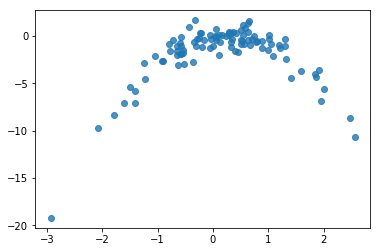

In [10]:
sns.regplot(X, y, fit_reg=False)
plt.show()

#### **Leave-One-Out Cross Validation**

According to [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html), LOOCV is the same as `KFold(n_splits)`, which is obvious. So I'll just use KFold with `n_splits=n`.

In [35]:
scores = []
for porder in np.arange(1, 5):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linreg', LinearRegression())])
    k_fold = KFold(n_splits=len(X))
    test = cross_val_score(model, X.reshape(-1, 1), y, cv=k_fold, scoring='neg_mean_squared_error')
    scores.append(np.mean(test))
print(scores)

[-9.661427583408592, -0.8511228571299867, -0.8669069848185395, -0.8888056674096625]


For fun, I also do other kinds of validation:

#### **KFold**

In [42]:
scores = []
for porder in np.arange(1, 5):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linreg', LinearRegression())])
    k_fold = KFold(n_splits=5)
    test = cross_val_score(model, X.reshape(-1, 1), y, cv=k_fold, scoring='neg_mean_squared_error')
    scores.append(np.mean(-test)) #negative sign because cross_val_score return negative vals
    
print(scores)

[10.76541452443797, 0.8353562927606714, 0.8547916893406058, 0.8661035747304389]


**Note:** Can use the following code to get a list of valid scorers.

In [43]:
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())

#### **Bootstrap**

In [63]:
def alpha(predictor, response, index):
    X = predictor[index]
    Y = response[index]
    return (np.var(Y) - np.cov(X,Y)[0,1])/(np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0,1])

alpha(predictor=X, response=y, index=np.arange(0, 100))

0.9650294576421797

In [90]:
def bootstrap(predictor, response, input_fun, iteration):
    """ Records estimates of alpha and returns its mean and std dev."""
    data = np.vstack((response, predictor)).T
    n = len(data)
    idx = np.random.randint(0, n, (iteration, n))
    stat = np.zeros(iteration)
    for i in np.arange(len(idx)):
        stat[i] = input_fun(data[:,0], data[:,1], idx[i])
    
    print('Mean: {:.3f}\nStd dev: {:.3f}'.format(np.mean(stat), np.std(stat)))

bootstrap(X, y, alpha, 1000)

Mean: 0.041
Std dev: 0.077


Bootstrap is used to assess the variabality of the coefficient estimates. In this case, bootstrap is estimated a coefficient estimate of 0.041 with `std dev = 0.077`, which is somewhat close to MSE obtained with KFold and LOO with higher degree polynomials.

***

## Exercise 9

In [95]:
boston = sm.datasets.get_rdataset('Boston', package='MASS').data
boston.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


In [104]:
print('Mean:', np.mean(boston['medv']), ' | SE:', np.std(boston['medv'])/np.sqrt(len(boston)))

Mean: 22.532806324110698  | SE: 0.4084569346972867


In [282]:
# Estimating with bootstrap. Not sure if this is the most 
# elegant solution. There are modules to help with this,
# but I preferred creating my own solution

def bootstrap(X, iters=1):
    """ Estimating mu and SE with bootstrap method"""
    
    n = len(X)
    
    # Random n index numbers
    idx = np.random.randint(0, n , (iters, n))
    
    # Stores n random samples, each of size n
    samples = []
    
    # Stores means and std devs of each sample
    means = []
    std_devs = []
    
    # Computing for each sample
    for i in range(0, len(idx)):
        samples.append(X[idx[i]])
        means.append(samples[i].mean())
        std_devs.append(np.std(samples[i]))
    
    # Computing totals
    total_mean = np.mean(means)
    se = np.mean(std_devs)/np.sqrt(n)
    
    return total_mean, se

bootstrap(boston['medv'], iters=1000)

(22.528756916996052, 0.4078039336742418)

Bootstrap estimates are very close to true estimates.

In [283]:
results = bootstrap(boston['medv'], iters=1000)

print('Confidence interval:', results[0]-2*results[1], results[0]+2*results[1])

Confidence interval: 21.725629830207655 23.356100999831877


> Skipped next parts because very similar to the one above. A way to improve `bootstrap` function is to give the functionality where the user can specify what test statistic they want to estimate.

### $Fin$